Code to investigate the predictive models


In [312]:
#Read in the packages to use
import numpy as np
import pandas as pd
import math
import datetime
import os
import pathlib
import matplotlib.pyplot as plt
import earthpy as et
import pandas as pd
import pickle
#for displaying the cities on map
import cartopy
import cartopy.crs as ccrs

#models
from sklearn.linear_model import LinearRegression 
import statsmodels.api as sm #stats models to get linear reg p-values
import itertools #for calculating possible combinations of variables
from sklearn.preprocessing import PolynomialFeatures #for polynomial regression
from sklearn.pipeline import make_pipeline #pipeline to create polynomial regression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
#use grid search to find hyperparameters (pg 73 Geron) RFR
from sklearn.model_selection import GridSearchCV #for cross validation

from sklearn.preprocessing import StandardScaler #for normalising the data
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#for plotting
from matplotlib import ticker 
from matplotlib.ticker import MaxNLocator #to keep whole numbers on the x-axis

#Read in the data

#read in the city info table
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))
CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon.xlsx', index_col=None)
#remove spokane
CITY_COUNTRY_lat_lon = CITY_COUNTRY_lat_lon.drop([16]).reset_index(drop = True)

#read the table with all variables in as pickle
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))   
with open('all_monthly_data_df2.pkl', 'rb') as f:
    all_monthly_data_df = pickle.load(f)
#remove spokane
#all_monthly_data_df = all_monthly_data_df[all_monthly_data_df['City'] != 'Spokane'].copy()

#remove nans
#all_monthly_data_df = all_monthly_data_df[(~np.isnan(all_monthly_data_df['rur_mean_evi'])
#                    ) & (~np.isnan(all_monthly_data_df['urb_mean_evi'])
#                    ) & (~np.isnan(all_monthly_data_df['a0']))].copy()

#add evi difference variable
all_monthly_data_df['evi_diff'] = all_monthly_data_df['rur_mean_evi'] - all_monthly_data_df['urb_mean_evi']

#split into training and test data
#take the test data as 4 cities, the training as 14?
#or test as 3 cities, training as 15

#define the test cities to remove
test_cities = ['Piracicaba', 'Ndola','Akola']

#define the overpass time 
overpass_time = '13:30'

#define the predictor and target values for training and test data
#what predictors to use?
predictor_variables_all = ['overall_evap_fract','overall_rh', 'urban_evap_fract', 'urban_rh', 'rural_evap_fract',
                       'rural_rh', 'overall_tp', 'rural_tp', 'urban_tp', 'overall_t2m','rural_t2m', 'urban_t2m', 
                        'overall_ssr','rural_ssr', 'urban_ssr','rur_mean_evi', 'urb_mean_evi','evi_diff']

#predictor_variables = ['rural_evap_fract', 'overall_rh','rur_mean_evi','evi_diff', 'rural_ssr']
predictor_variables = predictor_variables_all

target_variable = 'a0'

#clean the data - first remove columns which are not the target or predictor variables, then remove nans
variables = predictor_variables.copy()
variables.append(target_variable)
variables.append('City')
variables.append('Overpass')
all_monthly_data_df2 = all_monthly_data_df[variables]
all_monthly_data_df2 = all_monthly_data_df2.dropna()

#create training and test datasets
training_data = all_monthly_data_df2[((~all_monthly_data_df2['City'].isin(test_cities)) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()
test_data = all_monthly_data_df2[((all_monthly_data_df2['City'].isin(test_cities))
                                  & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()

print('Train_percent', 100* len(training_data)/len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))
print('Test_percent', 100* len(test_data)/len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))
print('Total Datapoints',len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))

#split the data into training and test

X_train = training_data[predictor_variables] #predictors
y_train = training_data[target_variable] #target

X_test = test_data[predictor_variables] #predictors
y_test = test_data[target_variable] #target

#create normalised datasets
#the test dataset is normalised using the normalisation parameters from the training data
scaler = StandardScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) #fit and transform
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) #transform only


Train_percent 84.14634146341463
Test_percent 15.853658536585366
Total Datapoints 3198


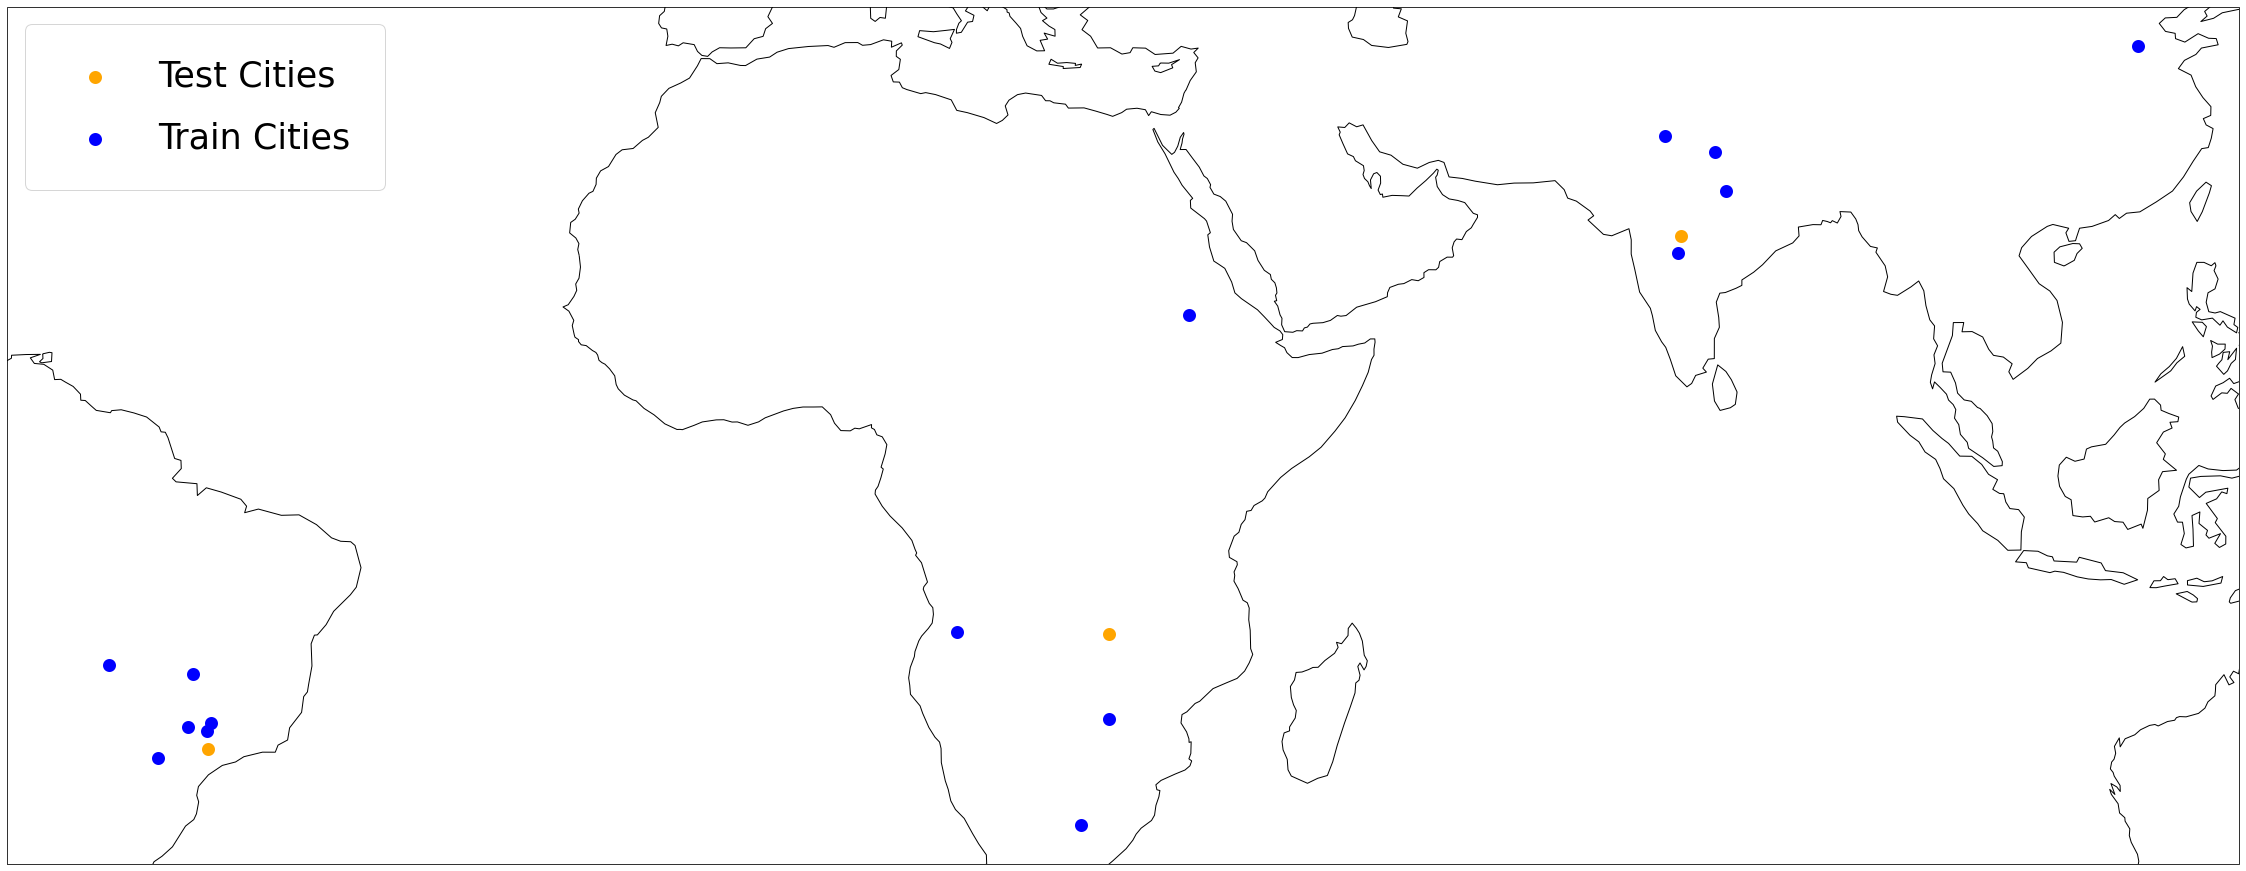

In [135]:
#Display train and test cities
#plot of where the test and training cities are located
fig = plt.figure(figsize=(40,35))

test_lats = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'].isin(test_cities)]['Lat']
test_lons = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'].isin(test_cities)]['Lon']

train_lats = CITY_COUNTRY_lat_lon[~CITY_COUNTRY_lat_lon['City'].isin(test_cities)]['Lat']
train_lons = CITY_COUNTRY_lat_lon[~CITY_COUNTRY_lat_lon['City'].isin(test_cities)]['Lon']

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

ax.scatter(test_lons, test_lats, zorder=5,color='orange', label='Test Cities', linewidths = 7.0)
ax.scatter(train_lons, train_lats, zorder=5,color='blue', label='Train Cities', linewidths = 7.0)

ax.legend(loc=2, borderpad = 1, fontsize = 35, labelspacing=0.8)

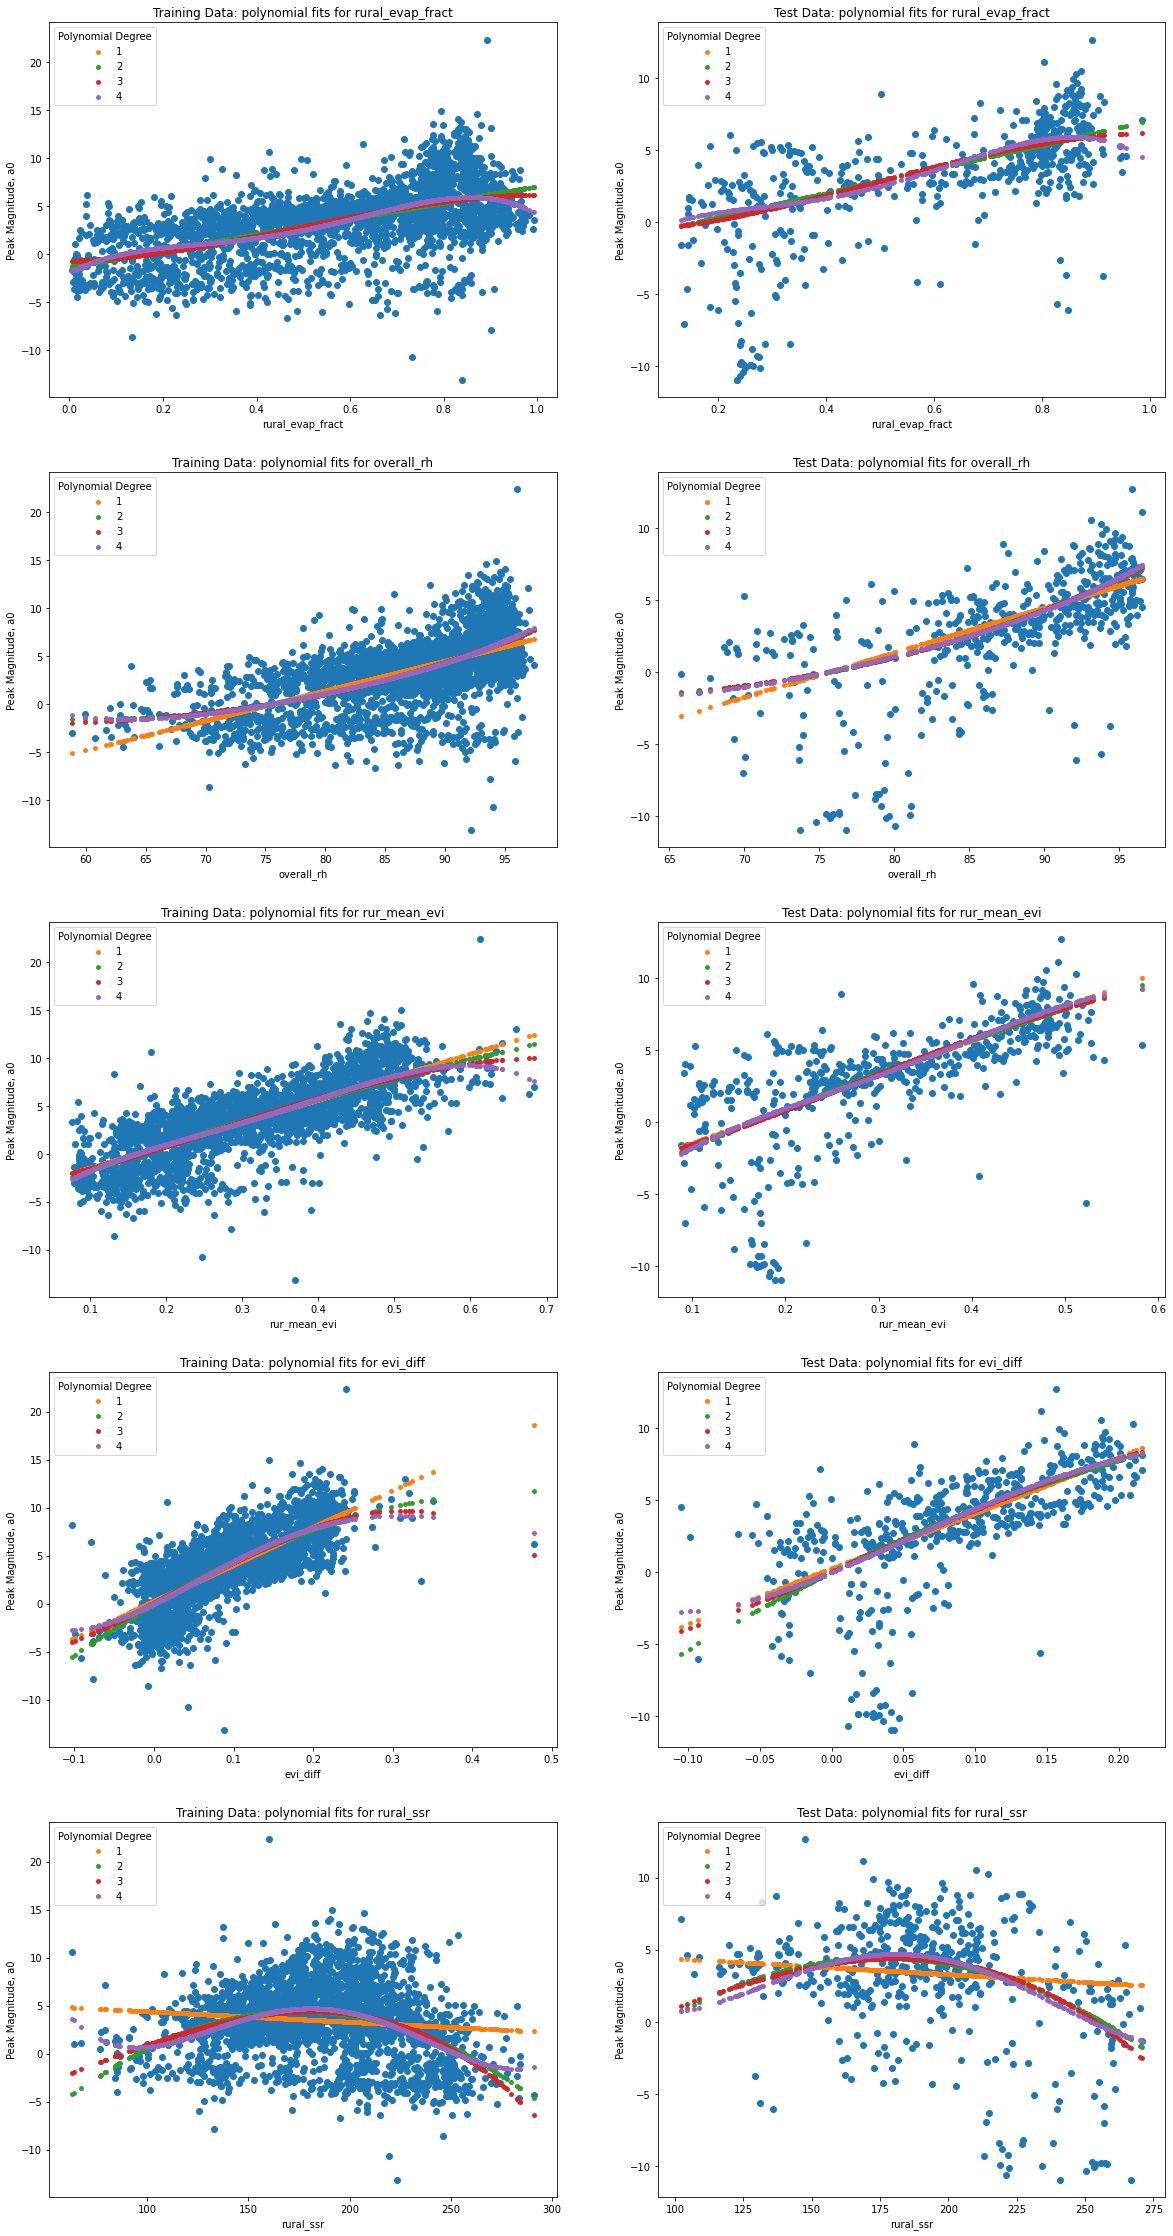

In [306]:
###### LINEAR REGRESSION ####################

#############################################
##### INPUT VARIABLES NOT NORMALISED ########
#############################################

#Linear Regression
#Looking at the individual variables 
#(includes polynomials but is linear in nature of the coefficients)
#create plots of each

#create the empty plots
num_cols = 2
num_rows = len(predictor_variables)

fig, axes = plt.subplots(num_rows,num_cols, figsize = (20, 8*num_rows))
#plt.subplots_adjust(hspace = 0.5)
#plt.subplots_adjust(wspace = 0.5)

#degrees of polynomial to fit
degrees = [1, 2,3,4]

for i1, predictor_variable in enumerate(predictor_variables):
    
    x_train = X_train[predictor_variable].values.reshape(-1, 1) #reshape due to required form
    x_test = X_test[predictor_variable].values.reshape(-1, 1)
    
    #plot the data
    #training data
    axes[i1,0].scatter(x_train, y_train)
    axes[i1,0].set(xlabel = predictor_variable, ylabel = 'Peak Magnitude, a0',
                   title = 'Training Data: polynomial fits for {}'.format(predictor_variable))
    #test data
    axes[i1,1].scatter(x_test, y_test)
    axes[i1,1].set(xlabel = predictor_variable, ylabel = 'Peak Magnitude, a0',
                   title = 'Test Data: polynomial fits for {}'.format(predictor_variable))   
    
    #create matrices to store the train and test predictions
    #each row is a data point, each column a prediction using a polynomial of some degree
    y_train_pred = np.zeros((len(x_train), len(degrees)))
    y_test_pred = np.zeros((len(x_test), len(degrees)))

    for i2, degree in enumerate(degrees):
    
        #make pipeline- create polynomial inputs, then feed them to lin reg model
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        model.fit(x_train, y_train)
    
        #predict on test and train data
        #store the predictions of each degree in the corresponding column
        y_train_pred[:, i2] = model.predict(x_train)
        y_test_pred[:, i2] = model.predict(x_test)
     
        #plot the polynomials
        axes[i1,0].scatter(x_train, y_train_pred[:, i2], s=15, label=str(degree)) #training data
        axes[i1,0].legend(loc='upper left', title = 'Polynomial Degree')
        axes[i1,1].scatter(x_test, y_test_pred[:, i2], s=15, label=str(degree)) #test data
        axes[i1,1].legend(loc='upper left', title = 'Polynomial Degree')


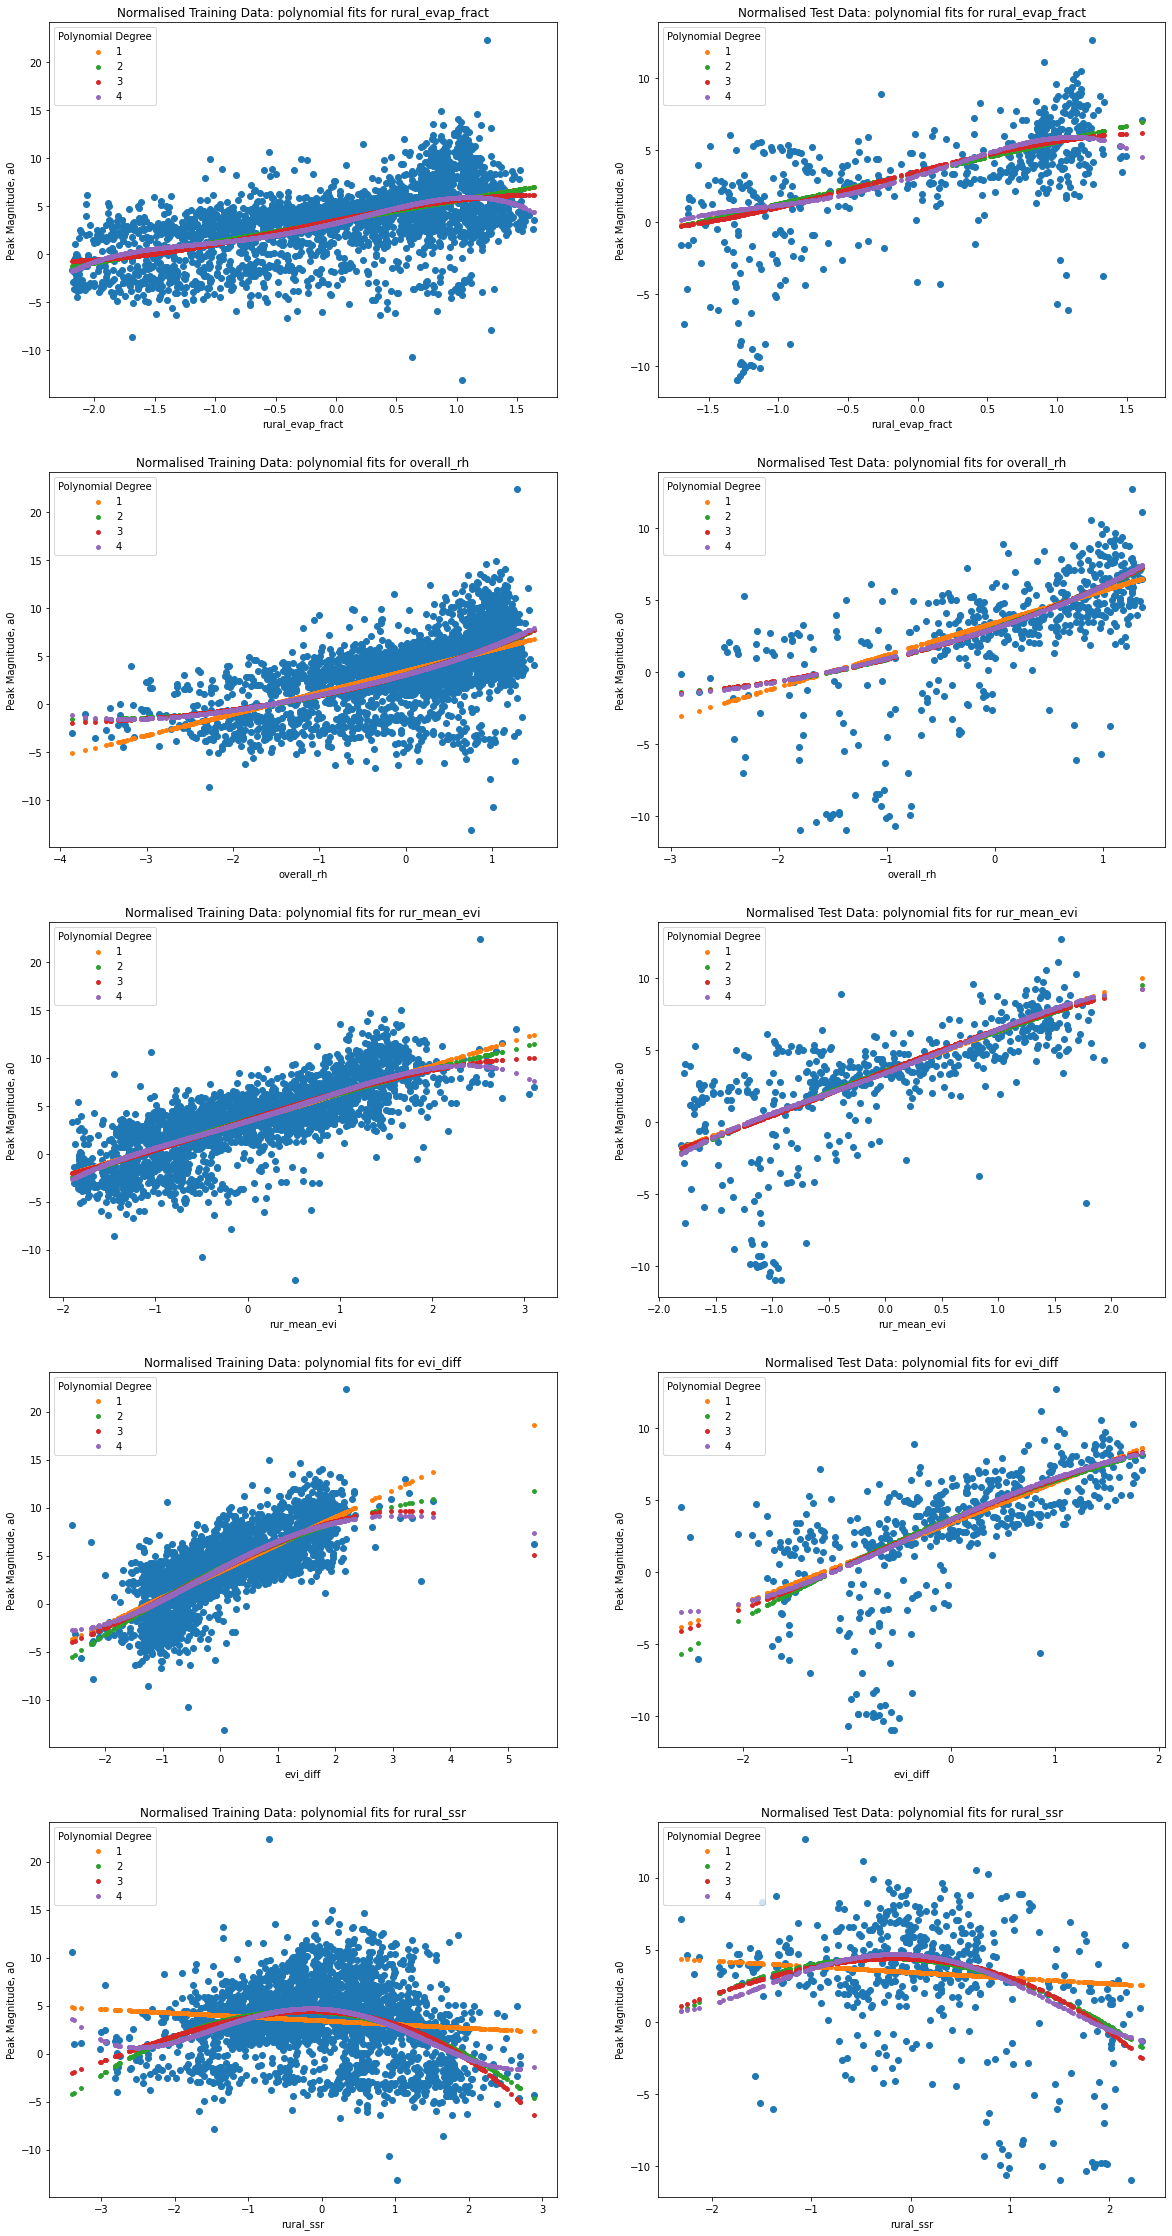

In [307]:
###### LINEAR REGRESSION ####################

#############################################
##### NORMALISED INPUT VARIABLES ############
#############################################

#Looking at the individual variables 
#(includes polynomials but is linear in nature of the coefficients)
#create plots of each

#create the empty plots
num_cols = 2
num_rows = len(predictor_variables)

fig, axes = plt.subplots(num_rows,num_cols, figsize = (20, 8*num_rows))
#plt.subplots_adjust(hspace = 0.5)
#plt.subplots_adjust(wspace = 0.5)

#degrees of polynomial to fit
degrees = [1, 2,3,4]

for i1, predictor_variable in enumerate(predictor_variables):
    
    x_train = X_train_norm[predictor_variable].values.reshape(-1, 1) #reshape due to required form
    x_test = X_test_norm[predictor_variable].values.reshape(-1, 1)
    
    #plot the data
    #training data
    axes[i1,0].scatter(x_train, y_train)
    axes[i1,0].set(xlabel = predictor_variable, ylabel = 'Peak Magnitude, a0',
                   title = 'Normalised Training Data: polynomial fits for {}'.format(predictor_variable))
    #test data
    axes[i1,1].scatter(x_test, y_test)
    axes[i1,1].set(xlabel = predictor_variable, ylabel = 'Peak Magnitude, a0',
                   title = 'Normalised Test Data: polynomial fits for {}'.format(predictor_variable))   
    
    #create matrices to store the train and test predictions
    #each row is a data point, each column a prediction using a polynomial of some degree
    y_train_pred = np.zeros((len(x_train), len(degrees)))
    y_test_pred = np.zeros((len(x_test), len(degrees)))

    for i2, degree in enumerate(degrees):
    
        #make pipeline- create polynomial inputs, then feed them to lin reg model
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        model.fit(x_train, y_train)
    
        #predict on test and train data
        #store the predictions of each degree in the corresponding column
        y_train_pred[:, i2] = model.predict(x_train)
        y_test_pred[:, i2] = model.predict(x_test)
     
        #plot the polynomials
        axes[i1,0].scatter(x_train, y_train_pred[:, i2], s=15, label=str(degree)) #training data
        axes[i1,0].legend(loc='upper left', title = 'Polynomial Degree')
        axes[i1,1].scatter(x_test, y_test_pred[:, i2], s=15, label=str(degree)) #test data
        axes[i1,1].legend(loc='upper left', title = 'Polynomial Degree')


In [308]:
#Multiple Linear Regression (MLR) (degree 1 (not polynomial))

##################################
####### Creating the model #######
##################################
#Create linear regression object
lin_reg = LinearRegression()

#fit the model
lin_reg.fit(X_train_norm, y_train)

#predict the training 
y_train_pred = lin_reg.predict(X_train_norm)
#predict the test
y_test_pred = lin_reg.predict(X_test_norm)

#intercept
lin_intercept = lin_reg.intercept_
print('Intercept -- ',lin_intercept)
#coefficients
lin_coef = lin_reg.coef_
print('Coefficients--')
for i in range(len(lin_coef)):
    print(predictor_variables[i],':', lin_coef[i])

######################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_lin_mse = mean_squared_error(y_train, y_train_pred)
train_lin_rmse = np.sqrt(train_lin_mse)
#r-square
train_lin_r2 = r2_score(y_train, y_train_pred)
#mae
train_lin_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', train_lin_rmse, 'R-square:', train_lin_r2, 'MAE:', train_lin_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_lin_mse = mean_squared_error(y_test, y_test_pred)
test_lin_rmse = np.sqrt(test_lin_mse)
#r-square
test_lin_r2 = r2_score(y_test, y_test_pred)
#mae
test_lin_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_lin_rmse, 'R-square:', test_lin_r2, 'MAE:', test_lin_mae)

Intercept --  3.456676950701783
Coefficients--
rural_evap_fract : -0.5175141885728727
overall_rh : 1.166348243982044
rur_mean_evi : 1.2601318050210775
evi_diff : 1.5782629711717064
rural_ssr : 0.7600039936520897
Training Metrics-- RMSE: 2.1938787738321954 R-square: 0.657114264412408 MAE: 1.6430579612889118
Test Metrics-- RMSE: 3.066204014274937 R-square: 0.44206585488473926 MAE: 1.9403915231903879


In [310]:
#Multiple Linear Regression (MLR) (degree 1 (not polynomial))

##################################
##### SUMMARY STATISTICS #########
##################################
#Carried out again in stats models library to get the p-values (no function to calculate these in scikit learn)
X_train1 = X_train_norm.to_numpy() #required form of X is an array
X_train2 = sm.add_constant(X_train1) #add intercept to model
est = sm.OLS(y_train, X_train2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                     a0   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     1030.
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        17:32:26   Log-Likelihood:                -5934.8
No. Observations:                2692   AIC:                         1.188e+04
Df Residuals:                    2686   BIC:                         1.192e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4567      0.042     81.658      0.0

In [ ]:
############################################
#### PERMUTATIONS OF LINEAR REGRESSIONS ####
############################################

#linear regression to test all permutations of predictor variables
#create a dataframe to fill
n = len(predictor_variables)
whole_grid = np.ones((1, n), dtype=int) #start with the case where all variables are included

for i in range(n-1):
    m = i+1
    which = np.array(list(itertools.combinations(range(n), m)))
    grid = np.zeros((len(which), n), dtype="int8")

    #add the combinations into the grid
    grid[np.arange(len(which))[None].T, which] = 1

    whole_grid = np.vstack((whole_grid, grid))
    
all_models = pd.DataFrame(data = whole_grid, columns = predictor_variables) #create a dataframe with all the combinations
all_models['AIC'] = np.nan #add in the test statistics
all_models['Ftest_pvalue']= np.nan
all_models['rmse'] = np.nan
all_models['rsquared'] = np.nan

#go through the table and calculate test statistics for models including combinations of pred variables
for i in range(len(all_models)):
    row = all_models.iloc[i] #take the row
    variable_list = []
    for p, predictor in enumerate(predictor_variables):
        if row[p] == 1:
            variable_list.append(predictor) #create list of the variables which are used in the row
    
    X_train_temp = X_train_norm[variable_list] #select the train variables to be used
    #not using test data for model validation/ selection as it must remain untouched
    #carry out the linear regression
    X_train_temp1 = X_train_temp.to_numpy() #required form of X is an array
    X_train_temp2 = sm.add_constant(X_train_temp1) #add intercept to model
    
    est = sm.OLS(y_train, X_train_temp2)
    est2 = est.fit()
    #add in the test statistics
    all_models.loc[i,'AIC'] =  est2.aic #AIC
    all_models.loc[i,'Ftest_pvalue']= est2.f_pvalue #f statistic p value
    all_models.loc[i,'rmse'] = np.sqrt(est2.mse_model) #mean square error
    all_models.loc[i,'rsquared'] =est2.rsquared #r square

#save the table as a pickle
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','predictive_models')) 
with open('all_variables_lin_reg.pkl', 'wb') as f:
    pickle.dump(all_models, f)

#for each number of predictor variables, select the model with the best r-squared
#add in the number of variables used in each model
all_models['num_variables'] = all_models[predictor_variables].sum(axis = 1)

#create empty dataframe to be filled
best_models = pd.DataFrame()
#select the models for each variable which have the best r-square
#best_models 
for i in range(len(predictor_variables)):
    max_rsquare = max(all_models[all_models['num_variables'] == (i+1)].rsquared)
    rows = all_models[(all_models['rsquared'] == max_rsquare)& (all_models['num_variables'] == (i+1))]
    best_models = best_models.append(rows)

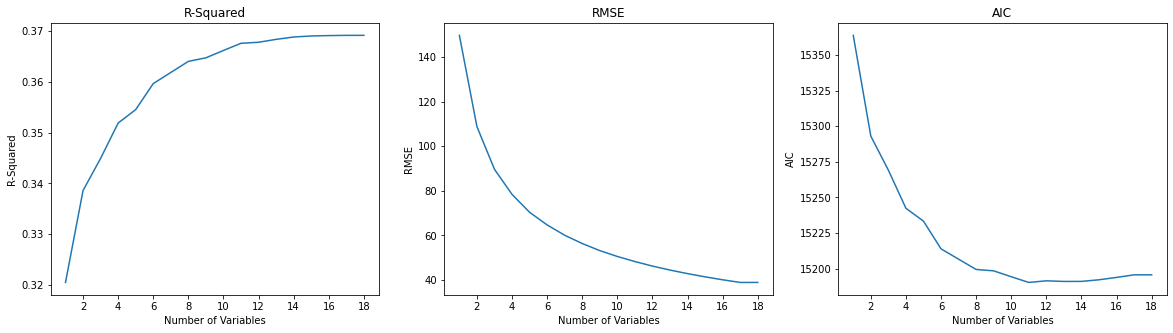

In [295]:
#plot the number of variables against the r-squared, AIC and rmse
fig, axes = plt.subplots(1,3, figsize = (20, 5))
axes[0].plot(best_models.num_variables, best_models.rsquared)
axes[0].set(xlabel = 'Number of Variables', ylabel = 'R-Squared', title = 'R-Squared')

axes[1].plot(best_models.num_variables, best_models.rmse)
axes[1].set(xlabel = 'Number of Variables', ylabel = 'RMSE', title = 'RMSE')

axes[2].plot(best_models.num_variables, best_models.AIC)
axes[2].set(xlabel = 'Number of Variables', ylabel = 'AIC', title = 'AIC')

xa = axes[0].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))
xa = axes[1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))
xa = axes[2].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))

In [ ]:
#Multiple Linear Regression (MLR) (degree 2 (polynomial))

    

In [ ]:
#Ridge regression model

In [ ]:
#generalised additive model (GAM) 

In [ ]:
#Random Forest regression (RFR)


